In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install openpyxl

In [ ]:
pip install xlrd

# Customer Segmentation with RFM

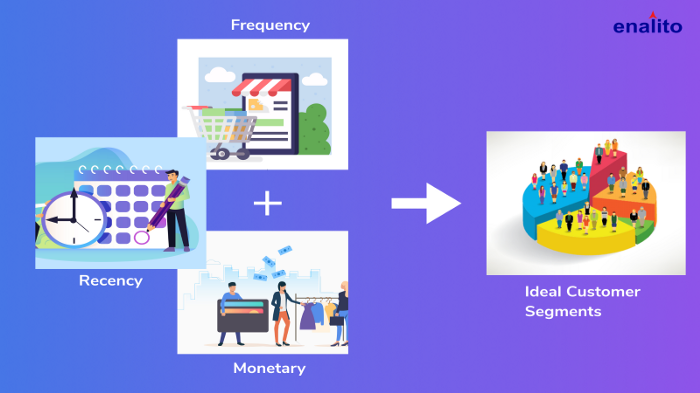

RFM Analysis is one of the most ideal methods to determine the groups of customers according to their purchasing behavior and to deal with them specifically according to their segments.

RFM consists of three dimensions:

**Recency:** The value that indicates how much time has passed since a customer's last activity or transaction with the brand. 
The activity is usually a purchase, but sometimes variations are used such as the last visit to a website or the use of a mobile app.

**Frequency:** How often a customer shows in a certain period of activity value. Customers who operate more often may be more loyal than others.

**Monetary:** It is the value that shows how much a customer has spent in a certain period of time. Dividing the value of the spend by frequency shows us the average purchase amount.

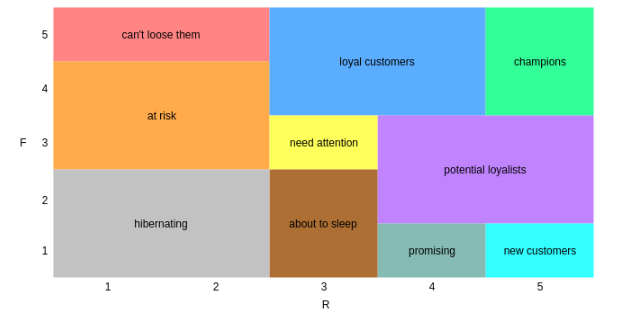

*Let's support this theoretical RFM knowledge with an exercise.*

# Data Set and Story

The data set called Online Retail II, which we will use in the exercise, includes the sales of a UK-based online retail store between the dates 01/12/2009 - 09/12/2011.

Variables of the data set:

* InvoiceNo : The number of the invoice, unique per each purchase. Refund invoice numbers contain "C"
* StockCode : Unique code per each item
* Description : Name of the item
* Quantity : The number of items within the invoice
* InvoiceDate : Date and time of the purchase
* UnitPrice : Price of a single item, as of Sterlin
* CustomerID : Unique id number per each customer
* Country : The country where the customer is living

*We got to know our data set. We can go into practice.*

In [ ]:
# Importing the libraries necessary for the exercise.
import datetime as dt
import pandas as pd

In [ ]:
# Reading and copying dataset
df_ = pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

# Looking at the first 5 rows of the data set
df.head()

In [ ]:
# Getting general information about the data set
df.info()

# Data Preparation

In [ ]:
# Looking at the descriptive statistics of the data set
df.describe().T

In [ ]:
# Setting an upper and lower limit for outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
# Replacing outliers with upper and lower limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [ ]:
# distribution looks more normal
df.describe().T

In [ ]:
# checking for null values
df.isnull().sum()

In [ ]:
# Remove null values
df.dropna(inplace=True)

In [ ]:
# Number of products
df["Description"].value_counts().head()

In [ ]:
# Unique number of products
df["Description"].nunique()

In [ ]:
# Order the total sales of products from high to low
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False).head()

In [ ]:
df["Invoice"].nunique()

In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]

We first looked at the unique values in the invoice number and these were 22190. Then we removed the returned parts of the Invoice variable and the unique values in the invoice number were reduced to 18536.

In [ ]:
df["Invoice"].nunique()

When we examine the data set, we see that there are variables that include the amount of purchase of a product and the price of that product, but it is not a variable that represents the total price earned from a product, and this is actually a required value for the Monetary value. To achieve this, we define a variable that indicates how much is earned from a product named "TotalPrice".

In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
# Looking at due date in data set
df["InvoiceDate"].max()

To calculate the recency value, we defined a variable called today_date. 
We have done 2 days longer than the deadline for this variable in the data. 
Our goal of doing this was to prevent the last date shoppers in the dataset from having a Recency value of 0.

In [ ]:
today_date = dt.datetime(2011, 12, 11)

# Creating RFM Metrics

In [ ]:
# We found the rfm values by grouping
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: len(num),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [ ]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In the code above:
* We introduced RFM values in the "Customer ID" breakdown.
* Subtracting date.max () from today_date variable on "InvoiceDate" variable and assigning it as days gave us the value of Recency.
* We obtained the value of Frequency by keeping the number of pieces of the “Invoice” variable with len () function.
* We obtained the Monetary value by taking the sum of the "TotalPrice" variable with the function sum ().
* We have assigned new column names to RFM

In [ ]:
# We removed the problematic data that did not show any fees even though there was a purchase.
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

We segmented our RFM values with the qcut () function. The high recency value means that the customer gets away from us. For this reason, we made the labels decreasing in order to avoid confusion.

In [ ]:
rfm["RecencyScore"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["MonetaryScore"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

In order to see the RFM values together, we defined a variable named "RFM_SCORE" and combined the RFM values by converting them to strings. If we tried to combine without converting, we might get an error because it would not combine the two categorical variables.

In [ ]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str) +
                    rfm['MonetaryScore'].astype(str))


The last step of our exercise is to assign labels to RFM values with the help of regex. The values in the seg_map dictionary give us our RFM values.
We have defined a variable named "segment" variable. This variable holds values representing segments of customers, corresponding to our R and F values. We used the replace () function to assign these values to the combination of R and F variables. Here the replace () function goes to the seg_map dictionary and keeps the variable R from the first value to the variable F from the second value and discards the corresponding value.

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

In [ ]:
rfm["Segment"] = (rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str))
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)

In [ ]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])

Now we can see the customer segments that we want to focus on. For the customer segment that they want to focus on, a marketing strategy can be chosen easily.

In [ ]:
# For example, if we want to examine loyal customers.
rfm[rfm["Segment"] == "Loyal_Customers"].head()

*Thank you for reading. 
I am waiting for your feedback.*